# Work description

This notebook is a part of exploratory work on textual image recognition. 
Global goal of this work is to create efficient pipelines for processing textual images. These pipelines will perform:

*   Image preprocessing
*   Text detection
*   Text recognition
*   Stamp recognition

In this notebook I'm preparing data for tf.data API and trying simple approaches to preprocess images.

Dataset used in this work

* DDI-100 dataset


# Imports

In [ ]:
import cv2
import random

import matplotlib.pyplot as plt


from random import choice
import numpy as np
import os

import tensorflow as tf
from tensorflow import keras

from google.colab.patches import cv2_imshow

#import pickle
#import zipfile
#from glob import glob
#from pathlib import Path

In [ ]:
#!cp "drive/My Drive/mylib.py"
#import mylib

# Data description and loading

### Description

DDI-100: Dataset for Text Detection and Recognition
https://arxiv.org/abs/1912.11658

The   DDI-100   dataset   contains   more   than   100000   distorted   images   of 7351unique documents  pages.  All  documents  are  in  the  public  domain  andinclude  various  reports, books, etc.

During the generation process 5659 different images were used as backgrounds and  textures  as  well  as  99  stamp  images.From  each  unique  document  page,  we  havecollected  15 different  images  by  applying  various  types  of  distortions  and  geometric transformations (Figure2). 

The list of all distortions is the following:
* perspective transformations;
* background replacement;
* document displacement;
* texture mapping;
* text and background overlay with various alpha channel;
* Gaussian and motion blur;
* adding color gradient;
* adding glares and shadows;
* image rescaling;
* stamp overlaying


Dataset is  divided  into  38  unequal  parts.  Every  part  corresponds  to  a  single  book  or report. Each folder contains the following information:

* original file in pdf format;
* original backgrounds as pdf file and as set of images;
* original masks as pdf file and asset of grayscale images;
* text masks as pdf file and as set of grayscale images;
* text blocks positions as set of pickle files;
* generated images;
* text blocks positions of generated images as set of pickle files;
* text masks of generated images;
* stamp masks of generated images.

## Creating generator for TF.data API to load images from DDI-100 archives

Image data weighs a lot, and I would prefer not to create copies of it of any kind (whether in a colab environment or in my drive). 

Since authors of DDI-100 dataset created a folder on google drive, I can easily add a shortcut of it to my drive, then mount it in colab and use this data, as if it were located on my drive.

That is why I want to access data from original DDI-100 google drive folder directly. The simplest approach would be to create generator functions, and then pass this functions to *tf.data.Dataset.from_generator*, which will create required datasets for us.

---


---


Result: Problematic. Since all files located in ".zip" archives, I have to open them, without extracting. For some reasons, this sometimes leads to google drive crashes, which interrupts data stream.

In [ ]:
def get_file_id(path):
  """
  From filepath to generated image file, extracts id of it's original image
  """
  stripped = path.split("gen_imgs/", 1)[1]
  return stripped.split("_", 1)[0]

# Size of original image in this dataset (should be inferred automatically)
IMAGE_SIZE = [2481, 1749]

def process_image(image, resize=False, channels=1):
  """
  Takes image as bytes and returns reshaped tensor
  """
  # turn png image into numerical tensor
  image = tf.image.decode_png(image, channels=channels)
  # Normalize color channels
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image
  if resize:
    image = tf.image.resize(image, size=IMAGE_SIZE)
  return image

In [ ]:
def image_pairs_generator(archives, data_path):
  """
  Takes path to files and list of ".zip" files to use.
  Return pairs of images from "gen_imgs" and "orig_texts" folders."
  """
  random.shuffle(archives)
  for archive_path in archives:
    print(data_path + archive_path)
    with zipfile.ZipFile(str(data_path + archive_path), 'r') as myzip:
      all_pathes = myzip.namelist()
      gen_imgs_pathes = [path for path in all_pathes if ("gen_imgs" in path) and (".png" in path)]
      orig_text_path = gen_imgs_pathes[0][:16] + "orig_texts/"
      
      random.shuffle(gen_imgs_pathes)
      for image_path in gen_imgs_pathes: 
        file_id = get_file_id(image_path)
        or_img_path = orig_text_path + file_id + ".png"
        
        img_str = myzip.read(image_path)
        orig_img_str = myzip.read(or_img_path)

        x = process_image(img_str)
        y = process_image(orig_img_str)
        yield x, y

In [ ]:
data_path = "/content/drive/My Drive/DDI-100_v1.4/"
archives_names = [path for path in os.listdir(data_path) if ".zip" in path]

In [ ]:
generator = lambda: image_pairs_generator(archives_names, data_path)

dataset = tf.data.Dataset.from_generator(generator,  
                            output_types=(tf.float32, tf.float32),
                            output_shapes = ((None, None, 1), (None,None, 1)))

In [ ]:
for x, y in dataset.take(1):
  img1 = x
  img2 = y

/content/drive/My Drive/DDI-100_v1.4/02.zip


In [ ]:
cv2_imshow(img2.numpy() * 255)

## Uploading data from my drive
Since I had some troubles with "Google Drive errors" when working with zip files, I decided to unpack some data into my drive.

In [ ]:
# Utility functions

IMAGE_SIZE = [2270, 1600]
BATCH_SIZE = 4
PREFETCH = 1

def get_file_id(path):
  """
  From filepath to generated image file, extracts id of it's original image
  """
  stripped = path.split("gen_imgs/", 1)[1]
  return stripped.split("_", 1)[0]

def process_image(image_path, resize=True, channels=1):
  """
  Takes image path and returns reshaped tensor
  """
  image = tf.io.read_file(image_path) # creates string tensor
  # turn png image into numerical tensor
  image = tf.image.decode_png(image, channels=channels)
  # Normalize color channels
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image
  if resize:
    image = tf.image.resize(image, size=IMAGE_SIZE)
  return image

# Turning data into batches
def create_data_batches(X, y, batch_size=BATCH_SIZE):
  """
  Takes filepathes and returns TF data object
  """
  data = tf.data.Dataset.from_tensor_slices((tf.constant(X), tf.constant(y))) 
  data = data.map(lambda X1,y1: (process_image(X1), process_image(y1)))
  # Consider additional shuffling                                    
  data_batch = data.batch(BATCH_SIZE).prefetch(PREFETCH)
    
  return data_batch

In [ ]:
# Get file pathes

data_path = "/content/drive/My Drive/DocumentProcessing/DDI_data/01/"
gen_data_path = data_path + "gen_imgs/"
# list of full filepathes to generated images
gen_img_pathes = [gen_data_path + img_name for img_name in os.listdir(gen_data_path) if ".png" in img_name]

orig_data_path = data_path + "orig_texts/"
# list of full filepathes to original text images
orig_img_pathes = [orig_data_path + get_file_id(img_path) + ".png" for img_path in gen_img_pathes]

NUM_IMAGES = len(gen_img_pathes)

#  Making splits

X, y = np.array(gen_img_pathes), np.array(orig_img_pathes)

train_split = int(NUM_IMAGES * 0.7)
test_split = train_split + (NUM_IMAGES - train_split) // 2
X_train, y_train = X[:train_split], y[:train_split]
X_valid, y_valid = X[train_split: test_split], y[train_split: test_split]
X_test, y_test = X[test_split:], y[test_split:]
X_train.shape, X_valid.shape, X_test.shape

((1134,), (243,), (243,))

In [ ]:
# Creating datasets

IMAGE_SIZE = [1600, 2270]
BATCH_SIZE = 4
PREFETCH = 1

train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid)
test_data = create_data_batches(X_test, y_test)

# **Basic preprocessing with supervised learning.**

The goal is to create a model that will preprocess images.

The first approach would be to implement something "quick" and considering the image size and limited GPU resourses, I need to consider "simple" model architechures.

I want to take a generated image (noisy) and return its original.

In terms of our data, we want to take images from "gen_imgs" folder and transform them into corresponding images from "orig_texts" folder.

Since we have clear input and output, this will be considered as supervised learning task.

---

Conclusions - working with whole images wasn't a good idea, since a simple network couldn't really grasp much from such complex data.


## **Autoencoder models**

I want to see whether convolutional layers can preserve the text when processing whole images

Note. We don't want to decrease image size significantly (strides, pooling), since we need to keep letters to be "readable". In original text images, letter size is about 20*20 pixels.



---
Result: Since network isn't robust enough to recognize letters in big image, simple approach of using autoencoder with shallow CNN  isn't working



In [ ]:
BATCH_SIZE = 8
PREFETCH = 1
IMAGE_SIZE = [2400, 1600]
train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid)
test_data = create_data_batches(X_test, y_test)

### First experiment: simple convolutional autoencoder.

Results: Model made the image white (which is reasonable, since we have high class imbalance in our target (much more white pixels, than black)

Note. I encountered crash due to lack of RAM. Solved by reducing batch size

In [ ]:
encoder = keras.models.Sequential([
    keras.layers.Conv2D(32, 9, strides = 2, activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, 3, activation="selu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="selu"),
])

decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, 3, strides=2, padding="VALID", activation="selu", input_shape=[196, 296, 128]),
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="VALID", activation="selu"),
    keras.layers.Conv2DTranspose(1, 3, strides=2, padding="VALID", activation="sigmoid"),
    tf.keras.layers.experimental.preprocessing.Resizing(1600, 2400)
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss="binary_crossentropy", optimizer=keras.optimizers.SGD(lr=1.0))

In [ ]:
#history = autoencoder.fit(train_data, epochs=2, validation_data=valid_data)
#autoencoder.save("/content/drive/My Drive/DocumentProcessing/Saved_models/0209_Conv_AE_basic.h5")

### Compensating imbalance in classes

I found that Focal loss can be good in such tasks, since it down-weights well-classified examples and focuses on hard examples.

Also changed optimizer (learning were too slow and I didn't want to do hyperparameter search) and activation (relu worked fine).

Note: I couldn't just add "class_weight" parameter to ".fit" method, since it's not supporting 3d data.


---


Result: Text isn't preserved in any way. Images became more "gray".


In [ ]:
keras.backend.clear_session()

import tensorflow_addons as tfa
fl = tfa.losses.SigmoidFocalCrossEntropy()

encoder = keras.models.Sequential([
    keras.layers.Conv2D(32, 9, strides = 2, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="relu"),
])

decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, 3, strides=2, padding="VALID", activation="relu", input_shape=[196, 296, 128]),
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="VALID", activation="relu"),
    keras.layers.Conv2DTranspose(1, 3, strides=2, padding="VALID", activation="sigmoid"),
    tf.keras.layers.experimental.preprocessing.Resizing(1600, 2400)
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss=fl, optimizer="nadam")


In [ ]:
history = autoencoder.fit(train_data, epochs=2, validation_data=valid_data)

Epoch 1/2
142/142 [==============================] - 213s 2s/step - loss: 0.1899 - val_loss: 0.1876
Epoch 2/2
142/142 [==============================] - 213s 1s/step - loss: 0.1899 - val_loss: 0.1876


In [ ]:
#autoencoder.save("/content/drive/My Drive/DocumentProcessing/Saved_models/0209_Conv_AE_FL.h5")

### Binary output

Changed activation function of the last layer from sigmoid to binary (to prevent network from making gray lists)

---
Result: images still "plain", and now consist of different black pixels densities. At this stage it's becoming obvious that a simple convolutional model can't grasp letters.



In [ ]:
keras.backend.clear_session()

binary_activation = lambda x: tf.nn.relu(tf.sign(x))

import tensorflow_addons as tfa
fl = tfa.losses.SigmoidFocalCrossEntropy()

encoder = keras.models.Sequential([
    keras.layers.Conv2D(64, 9, strides = 2, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="relu"),
])

decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, 3, strides=2, padding="VALID", activation="relu", input_shape=[396, 596, 128]),
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="VALID", activation="relu"),
    keras.layers.Conv2DTranspose(1, 3, padding="VALID", activation=binary_activation),
    tf.keras.layers.experimental.preprocessing.Resizing(1600, 2400)
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss=fl, optimizer="nadam")

In [ ]:
history = autoencoder.fit(train_data, epochs=2, validation_data=valid_data)

Epoch 1/2
284/284 [==============================] - 506s 2s/step - loss: 0.1224 - val_loss: 0.1208
Epoch 2/2
284/284 [==============================] - 491s 2s/step - loss: 0.1224 - val_loss: 0.1208


Let's view some documents

In [ ]:
for test_gen, test_or in test_data.take(1):
  pass

In [ ]:
processed_im = autoencoder.predict(test_gen)

In [ ]:
cv2_imshow(test_gen[0].numpy() * 255)
cv2_imshow(processed_im[0] * 255)

### Pixelwise loss

Changed model architechure a bit (decreased dimensionality reduction of encoder)

To be confident with my optimization goal I wrote simple custom loss function. It also adds weight to black/white pixels

In [ ]:
def weighted_pixelwise_loss(class_weights=(0.7, 0.3)):
  """
  Logloss across all pixels.
  Class_weights = (black, white)
  """
  epsilon = keras.backend.epsilon()
  
  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    logloss = y_true * tf.math.log(y_pred) * class_weights[1] + (1 - y_true) * tf.math.log(1 - y_pred) * class_weights[0]
    return tf.math.log( - tf.reduce_sum(logloss))
  return loss

pix_loss = weighted_pixelwise_loss()

In [ ]:
keras.backend.clear_session()

encoder = keras.models.Sequential([
    keras.layers.Conv2D(32, 5, strides = 2, activation="relu"),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.MaxPool2D(pool_size=2),
    keras.layers.Conv2D(128, 3, activation="relu"),
])

decoder = keras.models.Sequential([
    keras.layers.Conv2DTranspose(64, 3, strides=2, padding="VALID", activation="relu", input_shape=[396, 596, 128]),
    keras.layers.Conv2DTranspose(32, 3, strides=2, padding="VALID", activation="relu"),
    keras.layers.Conv2DTranspose(1, 3, padding="VALID", activation="sigmoid"),
    tf.keras.layers.experimental.preprocessing.Resizing(1600, 2400)
])

autoencoder = keras.models.Sequential([encoder, decoder])

autoencoder.compile(loss=pix_loss, optimizer="nadam")

In [ ]:
history = autoencoder.fit(train_data, epochs=5, validation_data=valid_data)

Epoch 1/5
284/284 [==============================] - 549s 2s/step - loss: 12.1923 - val_loss: 12.4985
Epoch 2/5
284/284 [==============================] - 533s 2s/step - loss: 12.4183 - val_loss: 12.4985
Epoch 3/5
284/284 [==============================] - 533s 2s/step - loss: 12.4183 - val_loss: 12.4985
Epoch 4/5
284/284 [==============================] - 535s 2s/step - loss: 12.4183 - val_loss: 12.4985
Epoch 5/5
284/284 [==============================] - 533s 2s/step - loss: 12.4183 - val_loss: 12.4985


In [ ]:
#autoencoder.save("/content/drive/My Drive/DocumentProcessing/Saved_models/0209_Conv_AE_custloss.h5")

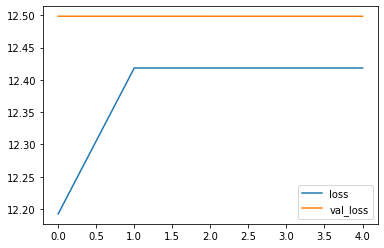

In [ ]:
import pandas as pd
pd.DataFrame(history.history).plot()
plt.show()

## **Simple convolutional models**

First I experimented with my loss function. Basically it's binary crossentropy (equivalent to logloss). But I added weighted term to punish uncertainty. Then experimented with it's parameters.

When there is not enough certainty in the model, it tends to output a lot of gray, not trying to preserve black.
When I added too much weight on a black (0.95, 0.05) with high certainty, model made background black.



---


Though image now is much better preserved (then autoencoder) and model tends to get rid of background images better, text is barely readable.

In [ ]:
# Due to mistake in image size, reloading data
IMAGE_SIZE = [2270, 1600]
BATCH_SIZE = 1
PREFETCH = 3

train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid)
test_data = create_data_batches(X_test, y_test)

### Baseline attempt with custom loss

In [ ]:
def weighted_pixelwise_loss(class_weights=(0.85, 0.15), certainty_power=2):
  """
  Logloss across all pixels.
  Class_weights = (black, white)
  """
  epsilon = keras.backend.epsilon()
  
  def loss(y_true, y_pred):
    y_pred = tf.clip_by_value(y_pred, epsilon, 1. - epsilon)
    logloss = y_true * tf.math.log(y_pred) * class_weights[1] + (1 - y_true) * tf.math.log(1 - y_pred) * class_weights[0]
    # To punish unceranty (0.5 outputs)
    weight_matr = (1 / (tf.math.abs(y_pred - 0.5) + 0.5)) ** certainty_power
    return tf.math.log( - tf.reduce_sum(logloss * weight_matr))
  return loss

pix_loss = weighted_pixelwise_loss(class_weights=(0.85, 0.15), certainty_power=3)

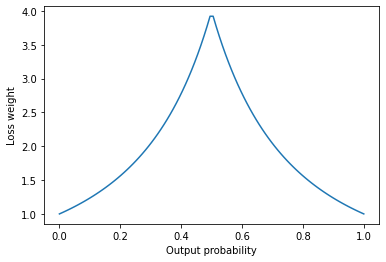

In [ ]:
# added punishing function for 0.5 probabilities
probs = np.linspace(0,1,100)
weights = (1 / (tf.math.abs(probs - 0.5) + 0.5)) ** 2

plt.plot(probs, weights)
plt.xlabel("Output probability")
plt.ylabel("Loss weight");

In [ ]:
keras.backend.clear_session()

import tensorflow_addons as tfa
fl = tfa.losses.SigmoidFocalCrossEntropy()

transformer = keras.models.Sequential([
    keras.layers.Conv2D(32, 6, activation="relu"),
    keras.layers.Conv2D(64, 3, activation="relu"),
    keras.layers.Conv2DTranspose(1, 1, activation="sigmoid"),
    tf.keras.layers.experimental.preprocessing.Resizing(2270, 1600)
])

transformer.compile(loss=pix_loss, optimizer="nadam")

In [ ]:
history = transformer.fit(train_data, epochs=1) #validation_data=valid_data)

567/567 [==============================] - 540s 953ms/step - loss: 13.1359


In [ ]:
#transformer.save("/content/drive/My Drive/DocumentProcessing/Saved_models/0209_Conv_Sequential.h5")

In [ ]:
for test_gen, test_or in test_data.take(1):
  pass

In [ ]:
#processed = transformer.predict(test_gen)
processed = model.predict(test_gen)

In [ ]:
n = 0
cv2_imshow(processed[n] * 255)
cv2_imshow(test_gen[n].numpy() * 255)
cv2_imshow(test_or[n].numpy() * 255)

### Building non-sequential network
Use of functional API to combine different kernel sizes for convolutions.

In [ ]:
# keras.layers.BatchNormalization()

inputs = keras.layers.Input(shape=[2270, 1600, 1])
c1 = keras.layers.Conv2D(32, 27, padding="SAME", activation="relu")(inputs)
c2 = keras.layers.Conv2D(32, 9, padding="SAME", activation="relu")(inputs)
c3 = keras.layers.Conv2D(32, 3, padding="SAME", activation="relu")(inputs)
concat = tf.concat((c1,c2,c3), axis=3)
cT = keras.layers.Conv2DTranspose(1, 1, activation="sigmoid")(concat)
outputs = tf.keras.layers.experimental.preprocessing.Resizing(2270, 1600)(cT)

model = keras.Model(inputs=[inputs], outputs=[outputs])

pix_loss = weighted_pixelwise_loss(class_weights=(0.75, 0.25), certainty_power=3)

model.compile(loss=pix_loss, optimizer="nadam")

In [ ]:
history = model.fit(train_data, epochs=1)

## **Images with removed background**
Using same models, but now we preprocessed images with OpenCV to remove background and make images more binary (black, white)

### Reworked preprocessing functions

In [ ]:
def process_image(image_path, resize=True, channels=1):
  """
  Takes image path and preprocess it and returns reshaped tensor
  """
  #print(image_path.numpy(), " a ", type(image_path.numpy()))
  image = cv2.imread(image_path.numpy().decode("utf-8"))
  image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
  segmented = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15)
  image = np.where(segmented == 255, segmented, image)

  image = tf.constant(np.expand_dims(image, axis = 2) / 255, tf.float32)
    
  # Resize image
  if resize:
    image = tf.image.resize(image, size=IMAGE_SIZE)
  return image


def process_target_image(image_path, resize=True, channels=1):
  """
  Takes image path and returns reshaped tensor
  """
  image = tf.io.read_file(image_path) # creates string tensor
  # turn png image into numerical tensor
  image = tf.image.decode_png(image, channels=channels)
  # Normalize color channels
  image = tf.image.convert_image_dtype(image, tf.float32)
  # Resize image
  if resize:
    image = tf.image.resize(image, size=IMAGE_SIZE)
  return image

# Turning data into batches
def create_data_batches(X, y, batch_size=BATCH_SIZE):
  """
  Takes filepathes and returns TF data object
  """
  data = tf.data.Dataset.from_tensor_slices((X, y))
  data = data.map(lambda X1,y1: (tf.py_function(process_image, inp=[X1], Tout=tf.float32), 
                                 process_target_image(y1)))
  # Consider additional shuffling                                    
  data_batch = data.batch(BATCH_SIZE).prefetch(PREFETCH)
    
  return data_batch

In [ ]:
IMAGE_SIZE = [2270, 1600]
BATCH_SIZE = 1
PREFETCH = 1

train_data = create_data_batches(X_train, y_train)
valid_data = create_data_batches(X_valid, y_valid)
test_data = create_data_batches(X_test, y_test)

for gen, orig in train_data.take(1):
  pass

In [ ]:
#cv2_imshow(gen[0].numpy() * 255)

### Sequential model

Result - not good, depends on cost function weights, resulted images were predominantly black or white.

In [ ]:
keras.backend.clear_session()


inputs = keras.layers.Input(shape=[2270, 1600, 1])
c1 = keras.layers.Conv2D(32, 6, activation="relu")(inputs)
c2 = keras.layers.Conv2D(64, 3, activation="relu")(c1)
cT = keras.layers.Conv2DTranspose(1, 1, activation="sigmoid")(c2)
outputs = tf.keras.layers.experimental.preprocessing.Resizing(2270, 1600)(cT)

transformer = keras.Model(inputs=[inputs], outputs=[outputs])

pix_loss = weighted_pixelwise_loss(class_weights=(0.6, 0.4), certainty_power=3)

transformer.compile(loss=pix_loss, optimizer="nadam")

In [ ]:
history = transformer.fit(train_data, epochs=1)

284/284 [==============================] - 707s 2s/step - loss: 16.6886


In [ ]:
#transformer.save("/content/drive/My Drive/DocumentProcessing/Saved_models/0309_Conv_cv2GaussPreproc.h5")
#transformer = tf.keras.models.load_model("/content/drive/My Drive/DocumentProcessing/Saved_models/0309_Conv_cv2GaussPreproc.h5", compile=False)
#transformer.compile(loss=pix_loss, optimizer="nadam")

In [ ]:
#for test_gen, test_or in test_data.take(1):
#  pass
processed = transformer.predict(test_gen)

In [ ]:
n = 0
cv2_imshow(processed[n] * 255)
cv2_imshow(test_gen[n].numpy() * 255)
cv2_imshow(test_or[n].numpy() * 255)

### Non-sequential

Plus fine tuned cost function

Result - Same as sequential

In [ ]:
inputs = keras.layers.Input(shape=[2270, 1600, 1])
c1 = keras.layers.Conv2D(32, 27, padding="SAME", activation="relu")(inputs)
c2 = keras.layers.Conv2D(32, 9, padding="SAME", activation="relu")(inputs)
c3 = keras.layers.Conv2D(32, 3, padding="SAME", activation="relu")(inputs)
concat = tf.concat((c1,c2,c3), axis=3)
cT = keras.layers.Conv2DTranspose(1, 1, activation="sigmoid")(concat)
outputs = tf.keras.layers.experimental.preprocessing.Resizing(2270, 1600)(cT)

model = keras.Model(inputs=[inputs], outputs=[outputs])

#import tensorflow_addons as tfa
#fl = tfa.losses.SigmoidFocalCrossEntropy()

pix_loss = weighted_pixelwise_loss(class_weights=(0.55, 0.45), certainty_power=3)

model.compile(loss=pix_loss, optimizer="adam")

In [ ]:
history = model.fit(train_data, epochs=1)

1134/1134 [==============================] - 803s 708ms/step - loss: 12.0529


In [ ]:
#model.save("/content/drive/My Drive/DocumentProcessing/Saved_models/0309_ConvNonSeq_cl_cv2GaussPreproc.h5")
#model = tf.keras.models.load_model("/content/drive/My Drive/DocumentProcessing/Saved_models/0309_ConvNonSeq_fl_cv2GaussPreproc.h5")

In [ ]:
transformed = model.predict(test_gen[0:1])

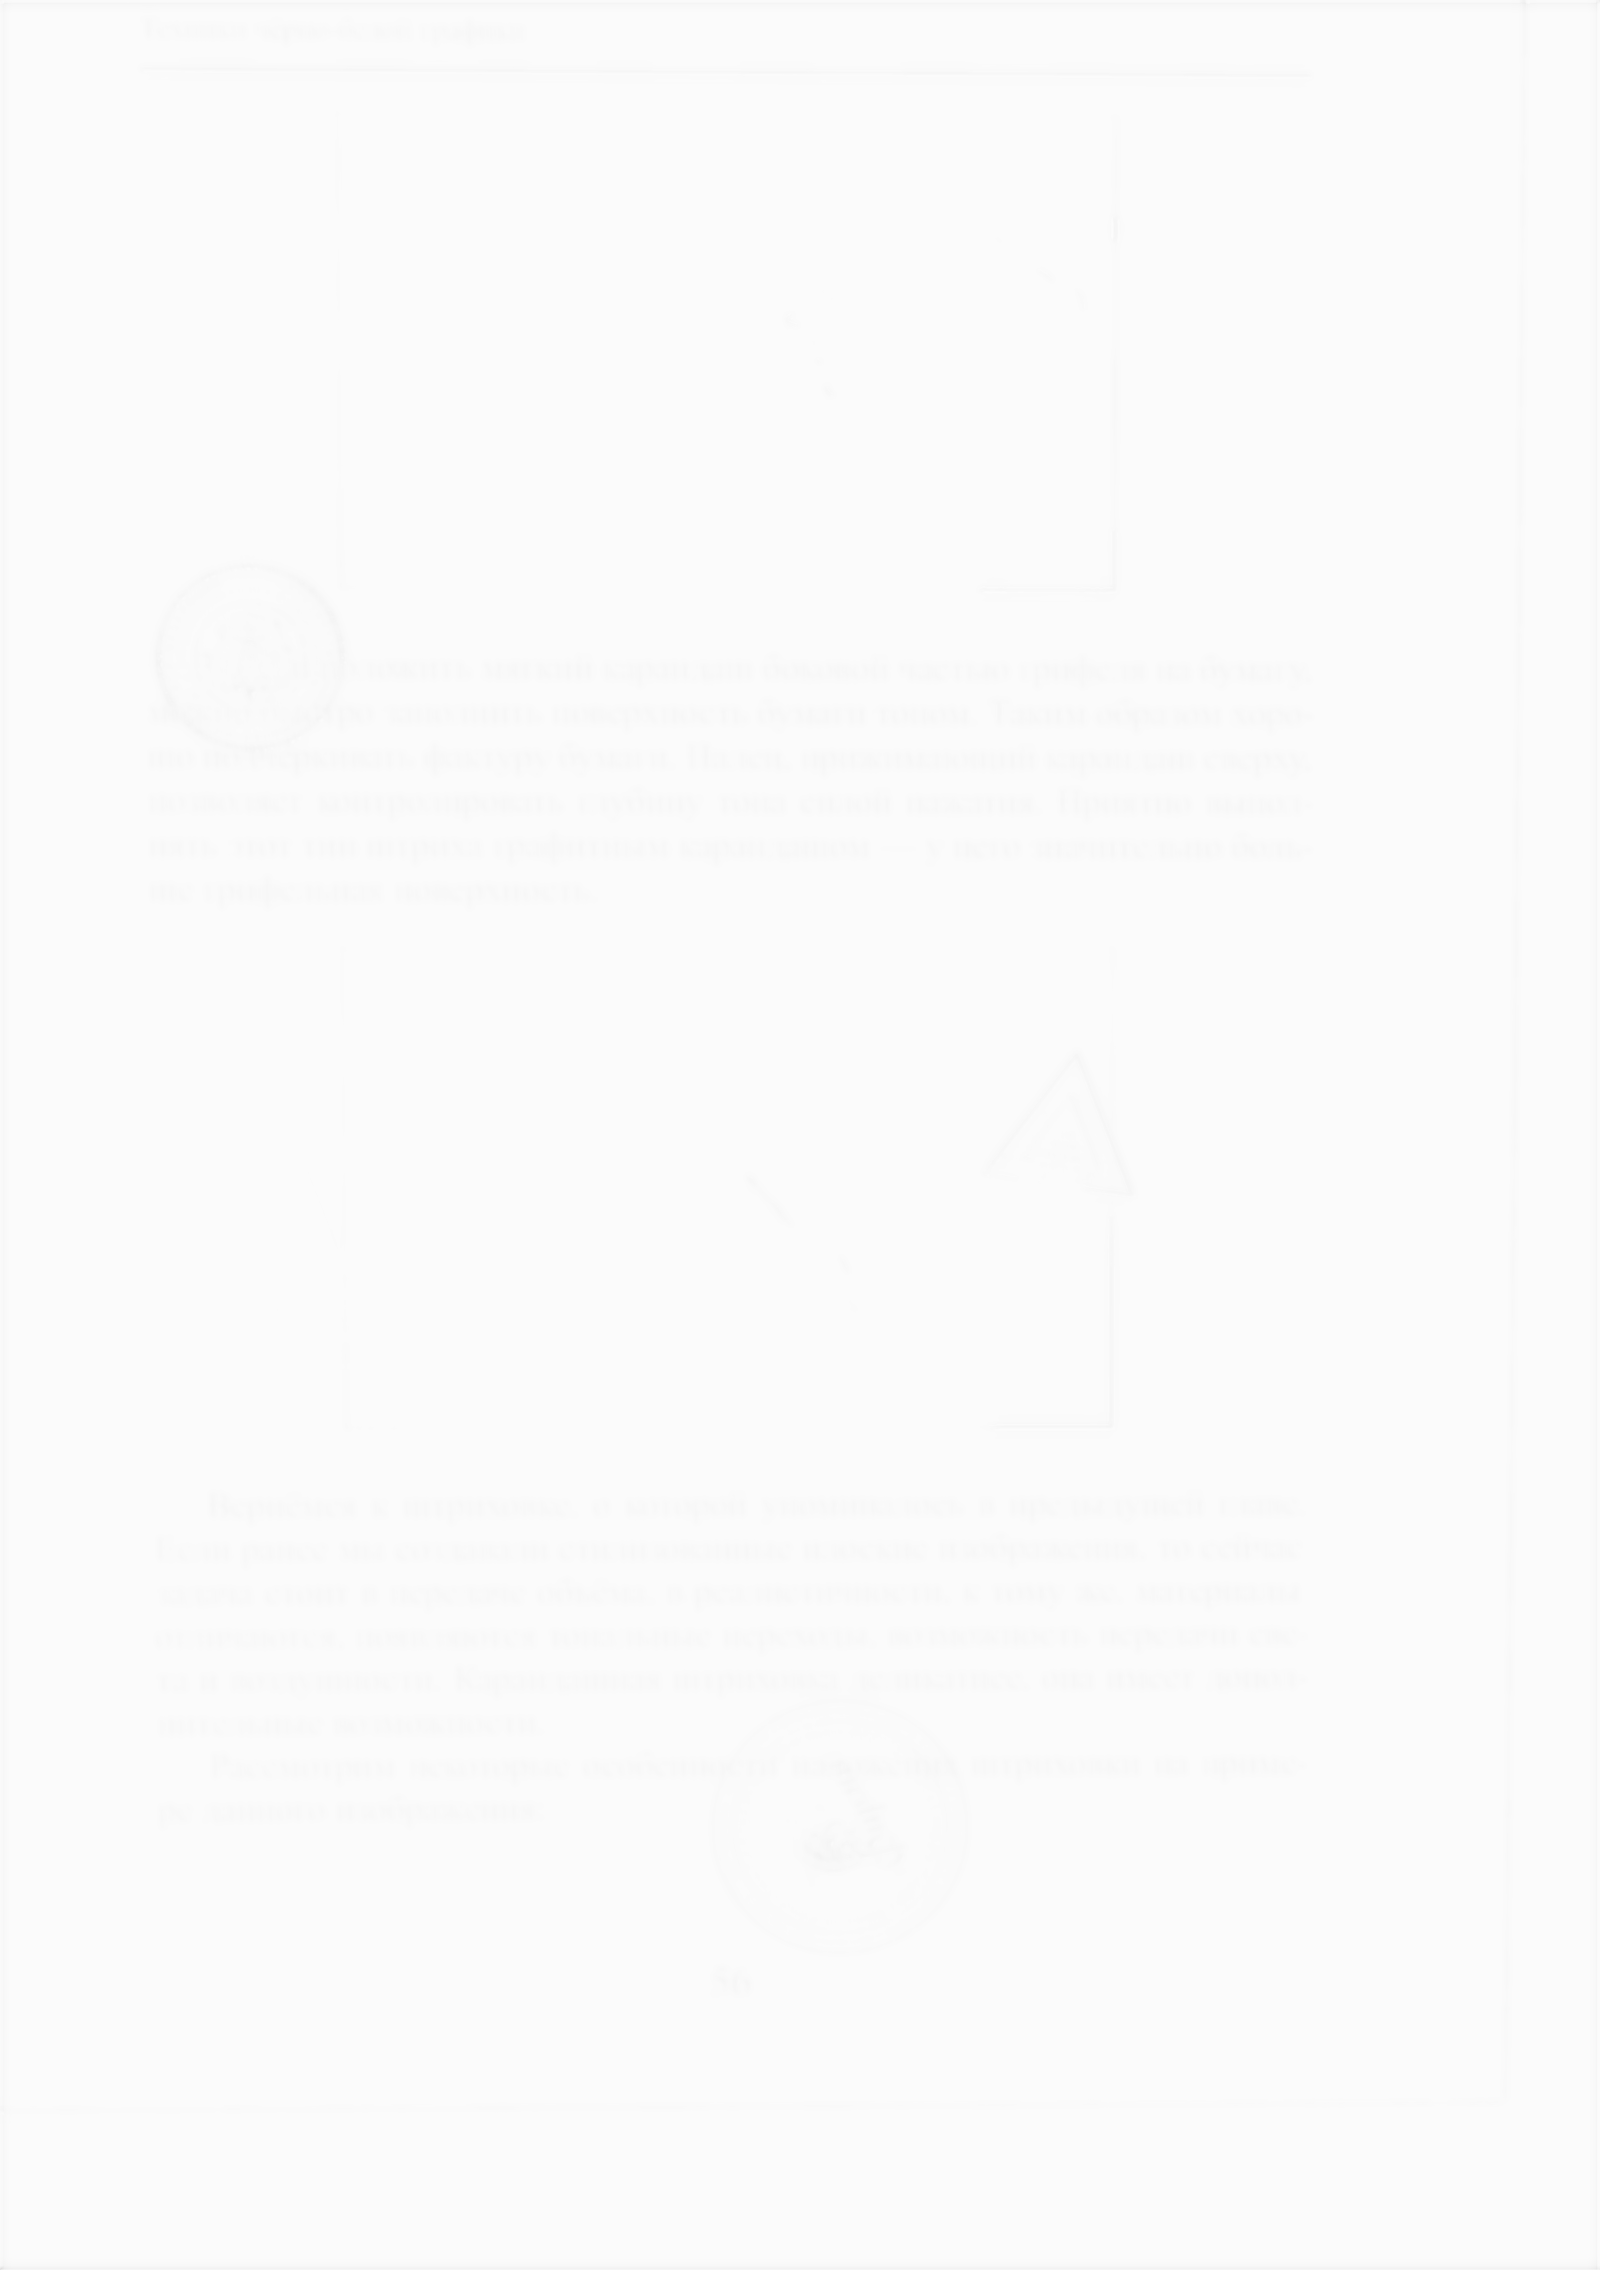

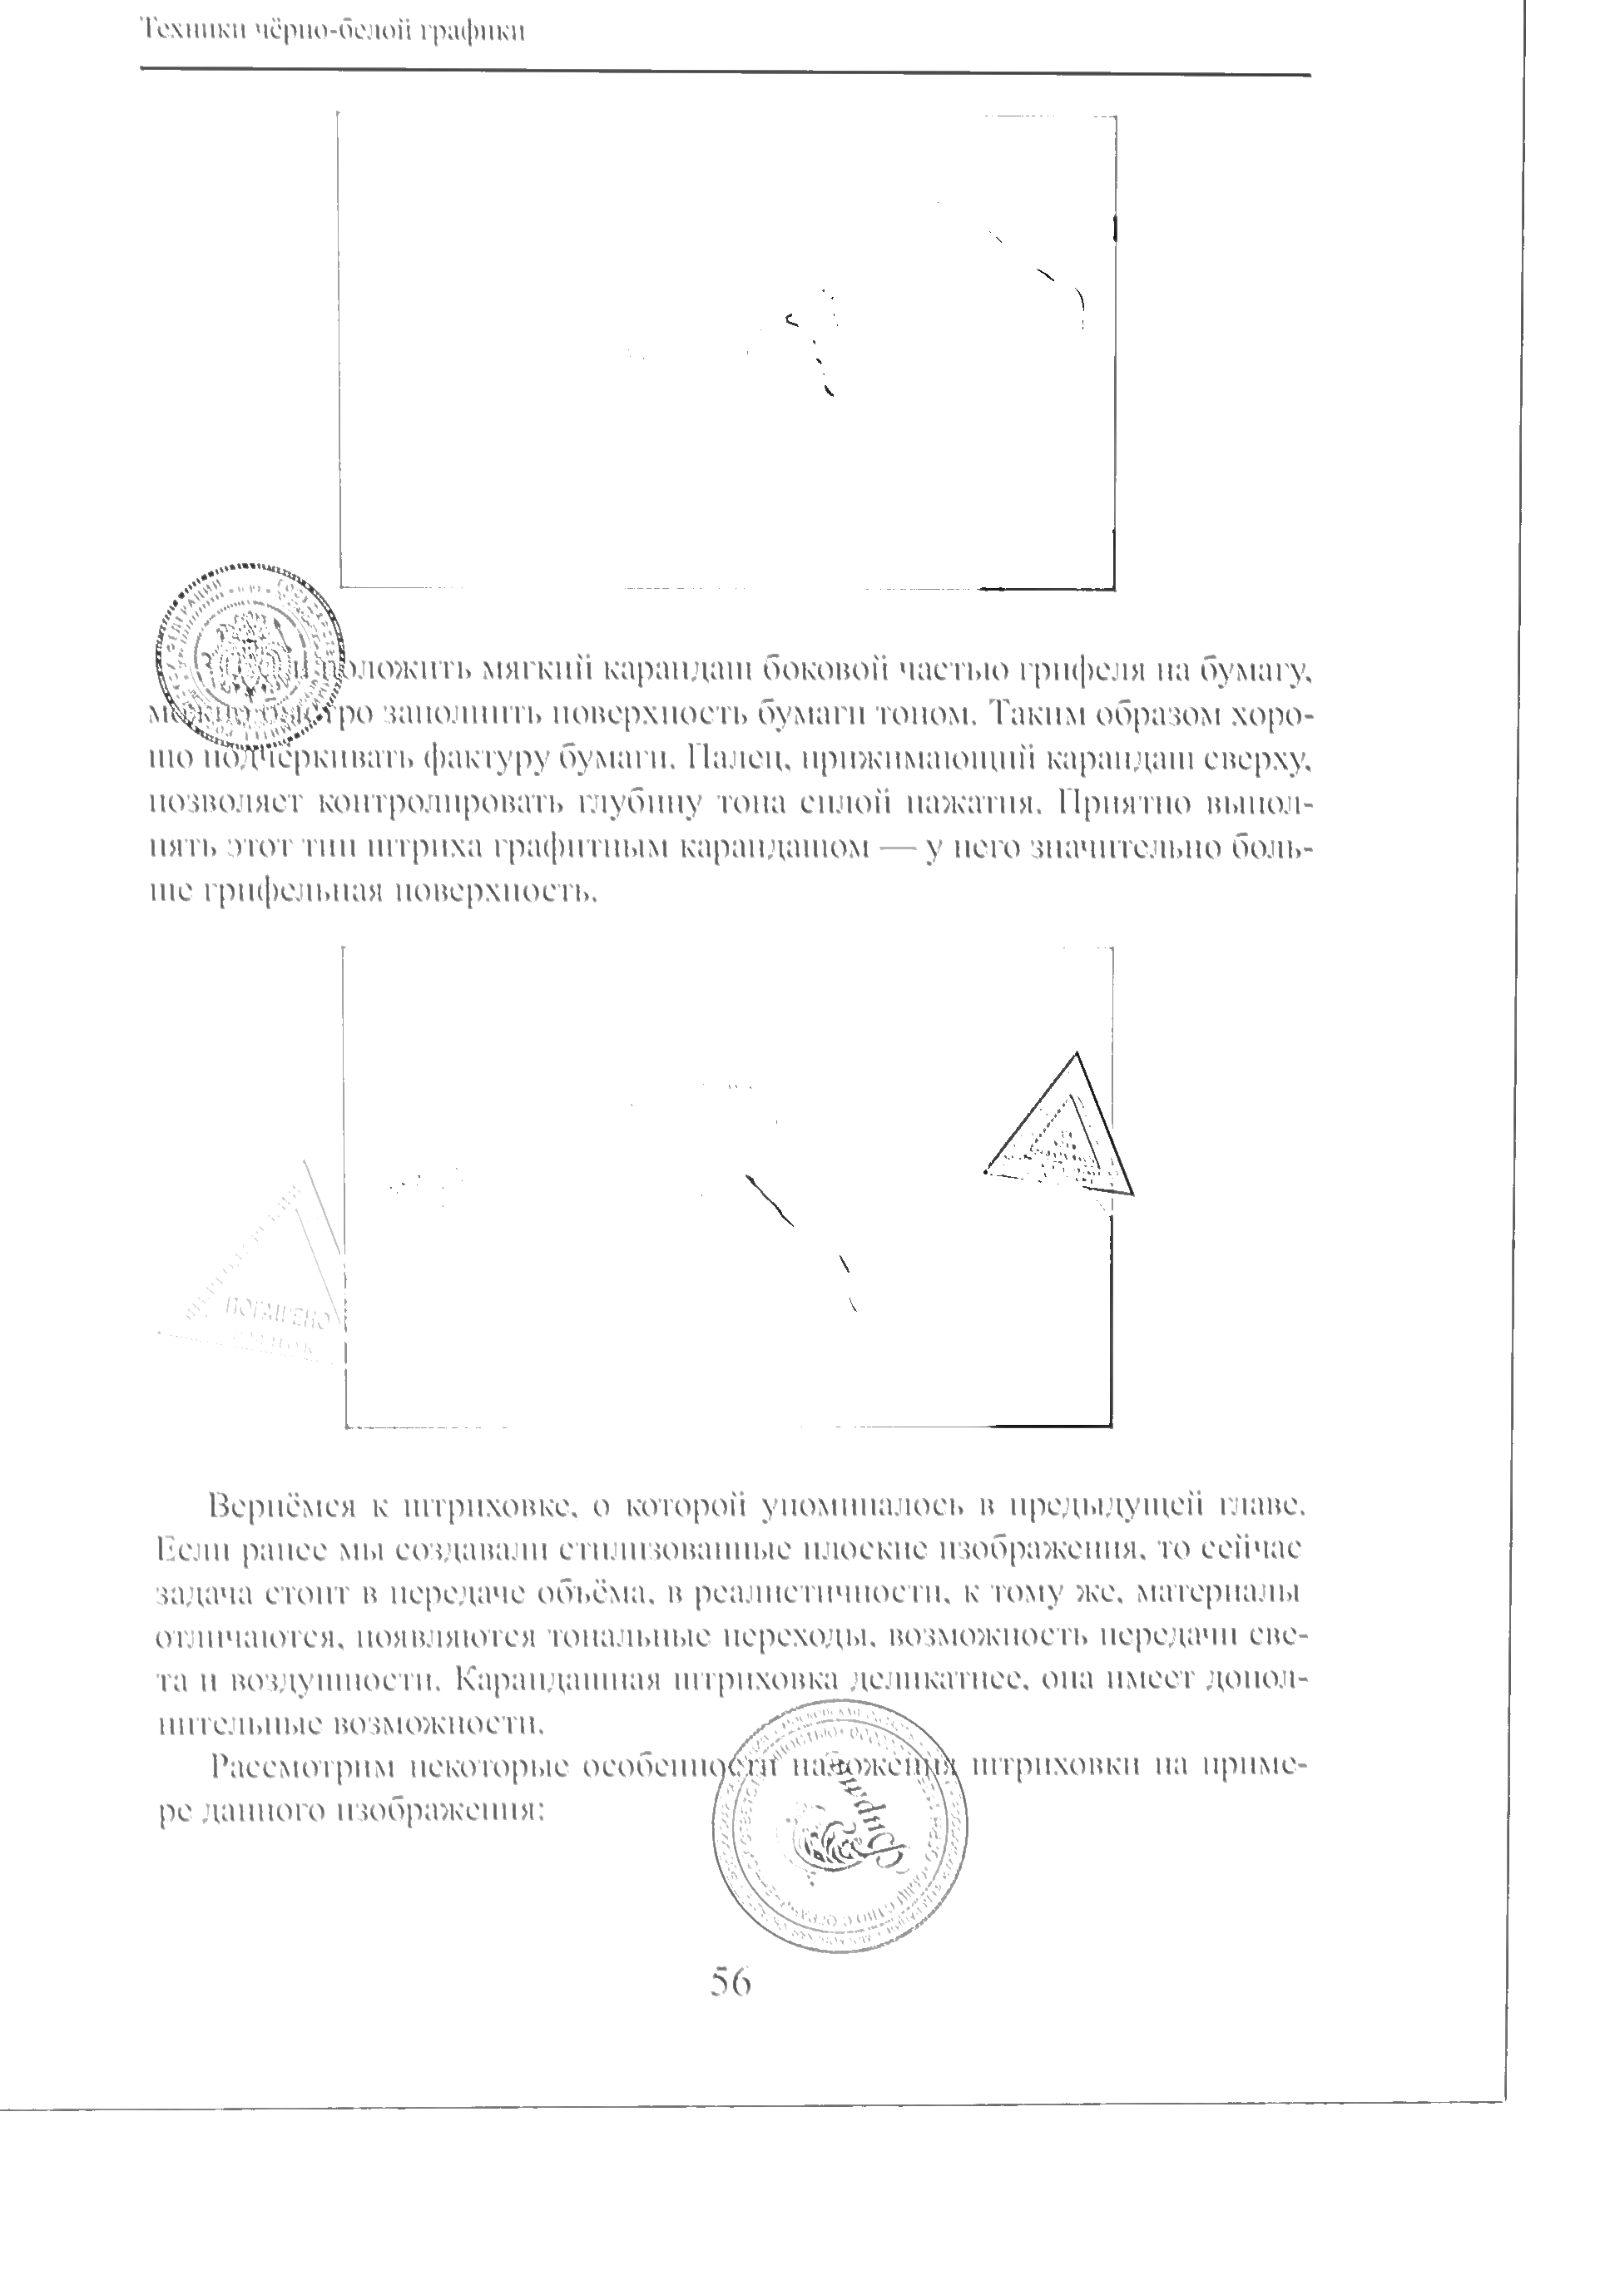

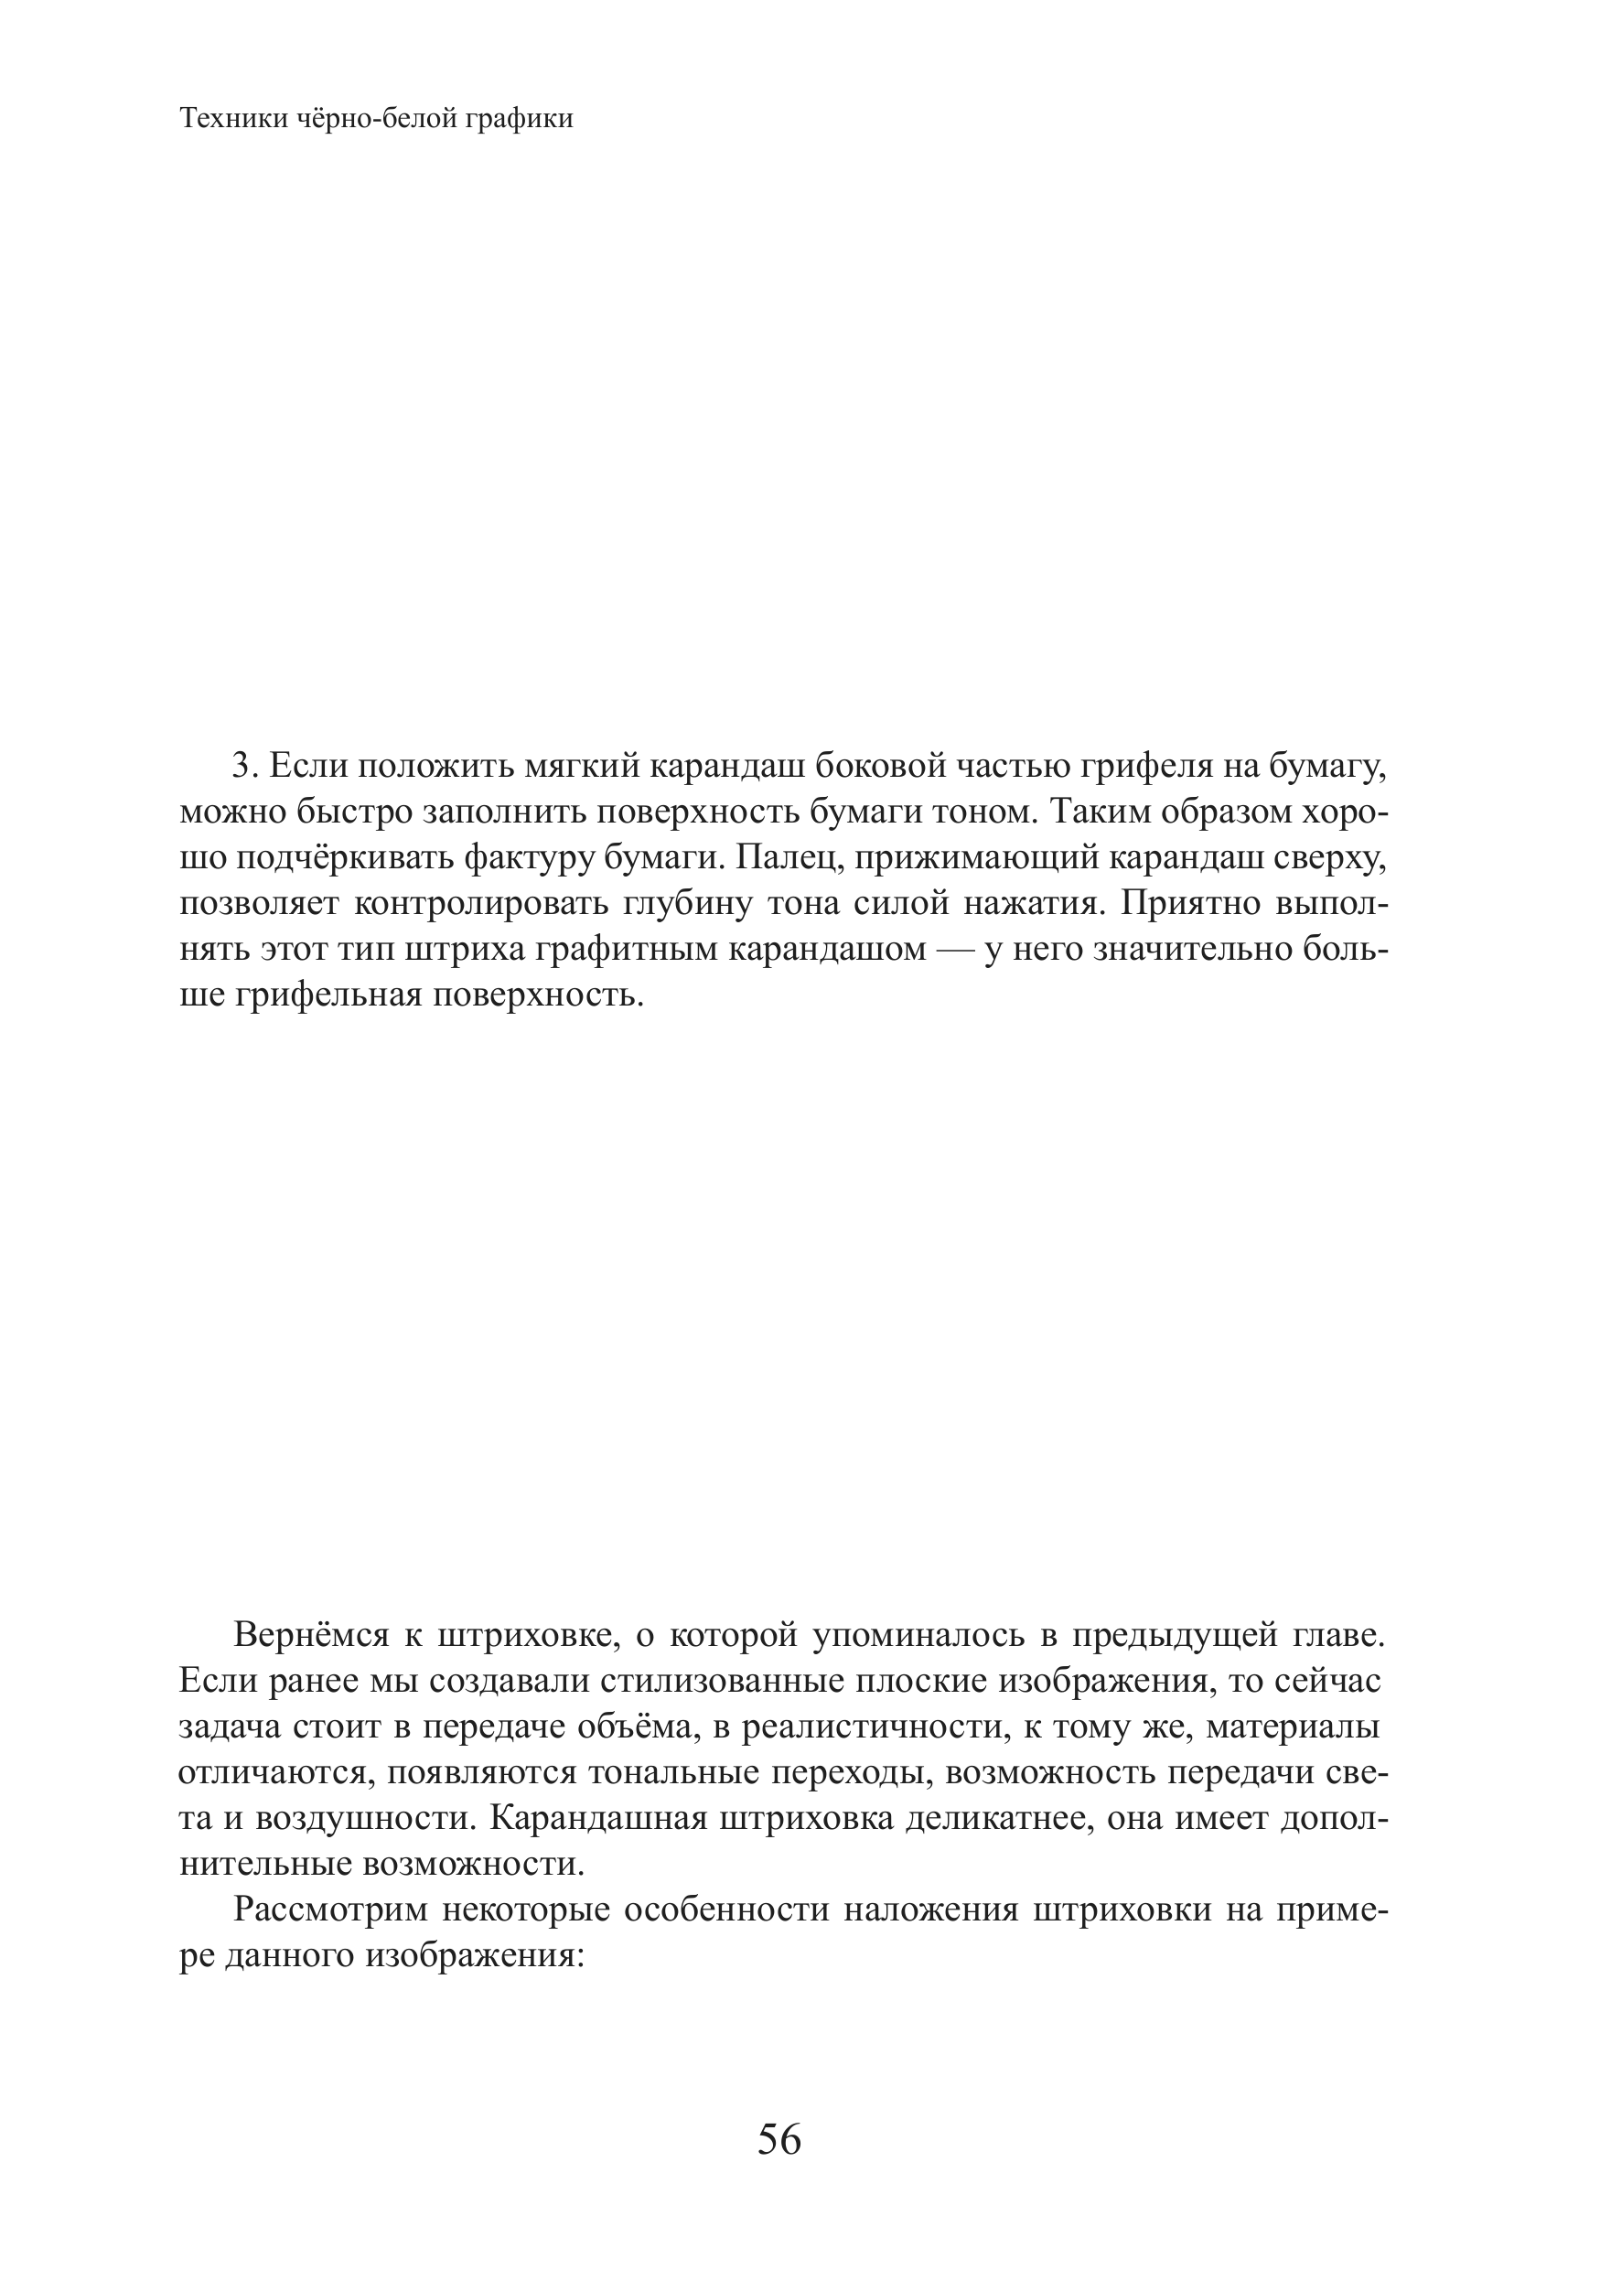

In [ ]:
n=0
cv2_imshow(transformed[n] * 255)
cv2_imshow(test_gen[n].numpy() * 255)
cv2_imshow(test_or[n].numpy() * 255)

# **Use of OpenCV for image preprocessing**

I wanted the model to brighten dark images and get rid of background.

Our sequential model somewhat handled this task, but if we could perform it at preprocessing stage, it would help the model to direct its powers onto more important tasks.

I've spent some time on OpenCV tutorial, so here will be some experiments with this library. I used it in "Images with removed background" section

---

Result - satisfying. Processed images contains readable text and white background. Though there are some black lines on the page edges and obviously picture contours are preserved. For now, I'll leave them be, hoping model will not confuse them with text.

## Data load plus utilities

In [ ]:
IMAGE_SIZE = [2270, 1600]
BATCH_SIZE = 10
PREFETCH = 0

train_data = create_data_batches(X_train, y_train)


for gen, orig in train_data.take(1):
  pass

#cv2_imshow(orig[2].numpy() * 255)

In [ ]:
# Display images
def plot_gray_images(images, single=False, labels=None, n_cols=5, figsize=(32,48)):
  plt.figure(figsize=figsize)
  if single:
    images = [images]
    n_rows = 1
  else:
    n = len(images)
    n_rows = n // n_cols + 1
  for i, image in enumerate(images):
    plt.subplot(n_rows, n_cols, i+1)
    plt.imshow(image, cmap="gray") # if shape (x,y, 1) .squeeze()
    plt.axis('off')
    if labels:
      plt.title(labels[i])

In [ ]:
images = np.array(gen * 255, dtype = np.uint8).reshape((gen.shape[0],2270, 1600))

image = np.array(gen[1] * 255, dtype = np.uint8).reshape((2270, 1600))

#plot_gray_images(image, single=True)

## Background removal

In [ ]:
def background_removal(images, blur=0, thresh=20):
  transformed = []
  for image in images:
    segmented = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,cv2.THRESH_BINARY,15,15)
    replaced = np.where(segmented == 255, segmented, image)
    transformed.append(replaced)
  return transformed

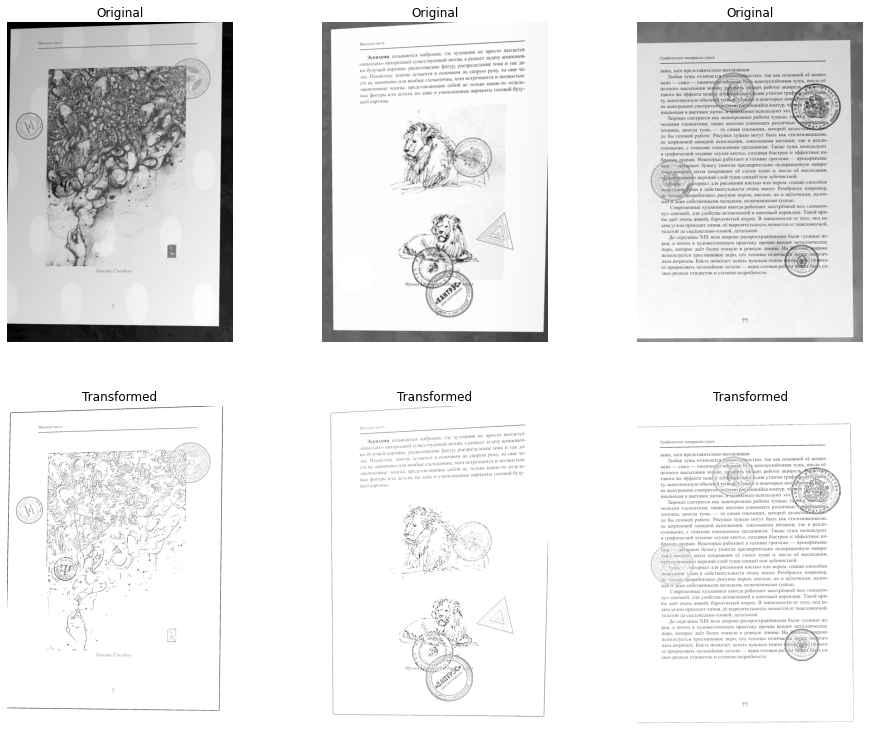

In [ ]:
transformed = background_removal(images[0:3], blur=0, thresh = 160)

plot_gray_images(np.r_[images[0:3], transformed], labels=['Original'] * 3 + ['Transformed'] * 3, figsize=(16, 20), n_cols=3)

# **Conclusions**

** Next notebook: Processing partial images. **

After several failures with simple convolutional layers, mostly because shallow (and small) CNN can't properly detect small features on such heavy images, I wanted to try a bit "bigger" models.
But more robust models couldn't fit data batches in the RAM (even a single image, since we need to preserve a lot of its filtered versions in CNN)

I had two ideas to address this problem.


* First. Split images into small ones in preprocessing step. 

This can reduce memory load, and allow me to build deeper models.

---

* Second. Classification of small part of an image

Since our original documents are all white with black letter, we could try to slide over an image, keeping all regions that contain text as it is (binary classification), and making it white if it doesn't. (But this won't solve overlapping problems, e.g. stamps)

# DDI 100 utilities

Code copied from dataset author's github. Mostly unused for now

## Generator Reworked (for reading from archives)

In [ ]:
class Generator:
  def __init__(self, archive_path):
    """
    Class Generator implements simple random sample choice.
    One of the arguments must be specified.
    :param pickle_path: str - path to pickle file with image paths
    :param dataset_path: str - path to full dataset
    :param book_paths: str - paths to book directories.
    """
    self.archive_path = archive_path


  def get_doc(self):
    """
    Returns random document sample from dataset.
    :return: (img, masks, data)
    """
    with zipfile.ZipFile(self.archive_path, 'r') as myzip:
      pathes = myzip.namelist()
      gen_imgs_pathes = [path for path in pathes if "gen_imgs" in path]
      
      path = choice(gen_imgs_pathes)
      img_path = Path(choice(gen_imgs_pathes))

      boxes_path = img_path.parent.parent.joinpath('gen_boxes').joinpath(img_path.stem + ".pickle")
      mask_paths = [path for path in pathes if ("gen_masks/" + img_path.stem + "_")  in path]
      #mask_paths = sorted(img_path.parent.parent.joinpath('gen_masks').glob(img_path.stem + '_*'))

      with myzip.open(str(boxes_path)) as f:
        data = pickle.load(f)
      
      with myzip.open(str(img_path)) as f:
        img_str = f.read()
        nparr = np.frombuffer(img_str, np.uint8)
        img = cv2.imdecode(nparr, 0)

      masks = []
      for mask_path in mask_paths:
        with myzip.open(mask_path) as f:
          img_str = f.read()
          nparr = np.frombuffer(img_str, np.uint8)
          mask_im = cv2.imdecode(nparr, 0)
        masks.append(mask_im)
    return img, masks, data

  def get_string(self):
    """
    Returns sample with random single word string from dataset.
    :return: (img, str, list) - img of word, string representation, list of char x axis delimiters
    """
    img, mask, data = self.get_doc()
    word = choice(data)
    cut_img, delimiters = get_image_from_box(img, word)
    shift = np.min(word['box'], axis=0)
    for char in word['chars']:
        char['box'] -= shift
    return cut_img, word['text'], delimiters

  def get_char(self):
    """
    Returns sample with random single char string from dataset.
    :return: (img, str) - img with letter and letter
    """
    img, _, boxes = self.get_doc()
    word = choice(boxes)
    char = choice(word['chars'])
    cut_img = get_image_from_box(img, char['box'])
    return cut_img, char['text']

## utils.py

In [ ]:
def draw_word_boxes(img, word_box_list, word_color=(0, 0, 0), letter_color=None, fill=False):
    """
    Draws boxes on the image. Inplace
    :param img: np.array - image
    :param word_box_list: list - boxes
    :param word_color: tuple or int or None - boundary color fow words
    :param letter_color: tuple or list or None - boundary color for letters
    :param fill: bool - whether to fill the boxes with color or just draw a quadrilateral
    """
    image = img.copy()
    thickness = -1 if fill else 2
    for word in word_box_list:
        if word_color is not None:
            image = cv2.polylines(image, [word['box'][[0, 1, 3, 2], ::-1].reshape((-1, 1, 2))], True, word_color,
                          thickness=thickness)

        if letter_color is not None:
            for char in word['chars']:
                image = cv2.polylines(image, [char['box'][[0, 1, 3, 2], ::-1].reshape((-1, 1, 2))], True, letter_color,
                              thickness=thickness)
    return image

def get_image_from_box(image, data, height=32):
    """
    Cuts image with bounding box using perspective Transform
    :param image: numpy.ndarray: image
    :param data: dict: corresponding word data box
    :param height: int: height of the result image
    :return: (np.ndarray, list): cut image, list of char x axis delimiters
    """
    box = data['box']
    scale = np.sqrt((box[0, 1] - box[1, 1])**2 + (box[0, 0] - box[1, 0])**2) / height
    w = int(np.sqrt((box[1, 1] - box[2, 1])**2 + (box[1, 0] - box[2, 0])**2) / scale)
    pts1 = np.float32(box)[:, ::-1]
    pts1 = pts1[[1, 0, 3, 2]]
    pts2 = np.float32([[0, 0], [height, 0], [0, w],  [height, w]])[:, ::-1]
    M = cv2.getPerspectiveTransform(pts1, pts2)
    result_img = cv2.warpPerspective(image, M, (w, height))

    begin = box[0][1]
    dist = (box[2][1] - begin)
    delimiters = []
    for (char, next_char) in zip(data['chars'], data['chars'][1:]):
        left = (char['box'][3][1] - begin) / dist * w
        right = (next_char['box'][0][1] - begin) / dist * w
        delimiters.append(int((left + right) / 2))
    return result_img, delimiters


def combine_masks(true_mask, predicted_mask):
    """
    Combines true and predicted masks into one image for convenient comparison.
    :param true_mask: 2D np.ndarray - gray image with true mask
    :param predicted_mask: 2D np.ndarray - gray image with predicted mask
    :return: 3D np.ndarray - colored image with both masks
    """
    if true_mask.shape != predicted_mask.shape:
        raise ValueError("Shapes do not match")
    if true_mask.ndim != 2:
        raise ValueError("Masks should be greyscaled")

    img = np.zeros(true_mask.shape + (3,))
    img[:, :, 2] = 255 - predicted_mask
    img[:, :, 1] = 255 - true_mask
    return img

## Displaying boxes around the words

In [ ]:
ARCHIVE_PATH = "/content/drive/My Drive/DDI-100_v1.4/01.zip"

In [ ]:
# Get random image (generator class lower)
gen = Generator(ARCHIVE_PATH)
img, masks, data = gen.get_doc()

# cv2_imshow(img)

In [ ]:
image = draw_word_boxes(img, data)

# or manually
# boxes = [box['box'][[0, 1, 3, 2], ::-1].reshape((-1, 1, 2)) for box in data]
# image = cv2.polylines(img, boxes, True, (0, 0, 0), 2) 

cv2_imshow(image)

## visualization.py

In [ ]:
def random_show(gen):
    img, mask, data = gen.get_doc()
    mask = mask[0].copy()
    cv2_imshow(cv2.resize(img, (0, 0), fx=0.2, fy=0.2))
    cv2_imshow(cv2.resize(mask, (0, 0), fx=0.2, fy=0.2))

    draw_word_boxes(img, data, word_color=0)
    cv2_imshow(cv2.resize(img, (0, 0), fx=0.2, fy=0.2))
    cv2.waitKey(1000)

## examples.py

In [ ]:
def test_doc():
    gen = Generator("../data/pdf_dataset")
    img, mask, data = gen.get_doc()
    cv2.imshow("image", cv2.resize(img, (0, 0), fx=0.2, fy=0.2))
    cv2.imshow("mask", cv2.resize(mask, (0, 0), fx=0.2, fy=0.2))
    draw_word_boxes(img, data, word_color=0)
    cv2.imshow("image with boxes", cv2.resize(img, (0, 0), fx=0.2, fy=0.2))
    cv2.waitKey()


def test_str():
    gen = Generator("../data/pdf_dataset")
    img, data, delimeters = gen.get_string()
    cv2.imshow("image", cv2.resize(img, (0, 0), fx=2, fy=2))
    print(data)
    for delim in delimeters:
        cv2.line(img, (delim, 0), (delim, 32), color=0, thickness=2)
    cv2.imshow("image with delims", cv2.resize(img, (0, 0), fx=2, fy=2))
    cv2.waitKey()


def test_char():
    gen = Generator("../data/pdf_dataset")
    img, data = gen.get_char()
    cv2.imshow("image", cv2.resize(img, (0, 0), fx=2, fy=2))
    print(data)
    cv2.waitKey()


def test_mask():
    gen = Generator("../data/pdf_dataset")
    _, mask1, _ = gen.get_doc()
    _, mask2, _ = gen.get_doc()
    mask2 = cv2.resize(mask2, (mask1.shape[1], mask1.shape[0]))
    img = combine_masks(mask1, mask2)
    cv2.imshow("image", cv2.resize(img, (0, 0), fx=.2, fy=.2))
    cv2.waitKey()


if __name__ == "__main__":
    test_doc()
    test_str()
    test_char()
    test_mask()